# Continuous Control

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the second project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
from unityagents import UnityEnvironment

import math
import random

import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Normal

from model import ValueNetwork, SoftQNetwork, PolicyNetwork
from util import ReplayBuffer, plot

In [2]:
from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

### 2. Next we active GPU support if available

In [3]:
use_cuda = torch.cuda.is_available()
device   = torch.device("cuda" if use_cuda else "cpu")

### 3. Below cell will launch the unity environment for reacher...

In [4]:
# Launch the environment
env = UnityEnvironment(file_name='Reacher.app')

# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

# Get environment info
env_info = env.reset(train_mode=True)[brain_name]

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


### 4. We now load our neural networks, our agent and define our optimizers and criterions.

In [5]:
action_dim = brain.vector_action_space_size
state_dim  = brain.vector_observation_space_size
hidden_dim = 256

print (action_dim)
print (state_dim)

value_net        = ValueNetwork(state_dim, hidden_dim).to(device)
target_value_net = ValueNetwork(state_dim, hidden_dim).to(device)

soft_q_net = SoftQNetwork(state_dim, action_dim, hidden_dim).to(device)
policy_net = PolicyNetwork(state_dim, action_dim, hidden_dim).to(device)

for target_param, param in zip(target_value_net.parameters(), value_net.parameters()):
    target_param.data.copy_(param.data)
    

value_criterion  = nn.MSELoss()
soft_q_criterion = nn.MSELoss()

value_lr  = 3e-4
soft_q_lr = 3e-4
policy_lr = 3e-4

value_optimizer  = optim.Adam(value_net.parameters(), lr=value_lr)
soft_q_optimizer = optim.Adam(soft_q_net.parameters(), lr=soft_q_lr)
policy_optimizer = optim.Adam(policy_net.parameters(), lr=policy_lr)


replay_buffer_size = 1000000
replay_buffer = ReplayBuffer(replay_buffer_size)

4
33


### 5. Let's define the number of episodes, steps and batch size for sampling from the replay buffer.

In [6]:
max_episodes  = 100000
max_steps   = 500
episode_idx   = 0
rewards     = []
batch_size  = 128

### 6. Below we define our soft q update rule as per the SAC paper

In [7]:
def soft_q_update(batch_size, 
           gamma=0.99,
           mean_lambda=1e-3,
           std_lambda=1e-3,
           z_lambda=0.0,
           soft_tau=1e-2,
          ):
    state, action, reward, next_state, done = replay_buffer.sample(batch_size)

    state      = torch.FloatTensor(state).to(device)
    next_state = torch.FloatTensor(next_state).to(device)
    action     = torch.FloatTensor(action).to(device)
    reward     = torch.FloatTensor(reward).unsqueeze(1).to(device)  # unsqueeze(1)
    done       = torch.FloatTensor(np.float32(done)).unsqueeze(1).to(device)  # unsqueeze(1)

    expected_q_value = soft_q_net(state, action)
    expected_value   = value_net(state)
    new_action, log_prob, z, mean, log_std = policy_net.evaluate(state)


    target_value = target_value_net(next_state)
    next_q_value = reward + (1 - done) * gamma * target_value
    q_value_loss = soft_q_criterion(expected_q_value, next_q_value.detach())

    expected_new_q_value = soft_q_net(state, new_action)
    next_value = expected_new_q_value - log_prob
    value_loss = value_criterion(expected_value, next_value.detach())

    log_prob_target = expected_new_q_value - expected_value
    policy_loss = (log_prob * (log_prob - log_prob_target).detach()).mean()
    

    mean_loss = mean_lambda * mean.pow(2).mean()
    std_loss  = std_lambda  * log_std.pow(2).mean()
    z_loss    = z_lambda    * z.pow(2).sum(1).mean()

    policy_loss += mean_loss + std_loss + z_loss

    soft_q_optimizer.zero_grad()
    q_value_loss.backward()
    soft_q_optimizer.step()

    value_optimizer.zero_grad()
    value_loss.backward()
    value_optimizer.step()

    policy_optimizer.zero_grad()
    policy_loss.backward()
    policy_optimizer.step()
    
    
    for target_param, param in zip(target_value_net.parameters(), value_net.parameters()):
        target_param.data.copy_(target_param.data * (1.0 - soft_tau) + param.data * soft_tau)


### 7. Now we let the agent learn by interacting with the environment and plotting the rewards...

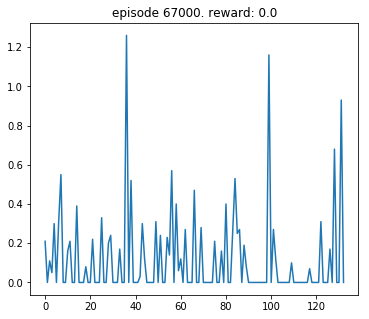

KeyboardInterrupt: 

In [8]:
while episode_idx < max_episodes:
    env_info = env.reset(train_mode=True)[brain_name]
    state = env_info.vector_observations[0]
    episode_reward = 0
    
    for step in range(max_steps):
        action = policy_net.get_action(state, device)
        env_info = env.step(action)[brain_name]
        next_state = env_info.vector_observations[0]
        reward = np.float64(env_info.rewards[0])
        done = env_info.local_done[0]
        
        replay_buffer.push(state, action, reward, next_state, done)
        if len(replay_buffer) > batch_size:
            soft_q_update(batch_size)
        
        state = next_state
        episode_reward += reward
        episode_idx += 1
        
        if episode_idx % 1000 == 0:
            plot(episode_idx, rewards)
        
        if done:
            break
        
    rewards.append(episode_reward)

In [ ]:
env.close()